<a href="https://colab.research.google.com/github/monicaneli/Metricas-Avaliacao-Aprendizado/blob/main/Metricas_Avaliacao_Aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação de Modelos de Classificação de Imagens utilizando Redes Neurais

Neste projeto, são apresentados os cálculos de métricas de avaliação de aprendizado para um modelo de classificação de imagens. A rede neural convolucional (CNN) foi aplicada a um problema de classificação multiclasse utilizando imagens da base de dados MNIST. O modelo implementado é uma CNN simples para classificação de imagens (10 classes), construída com a API Sequential do Keras.


In [103]:
# Imports e parâmetros
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

print(f"TensorFlor versão: {tf.__version__}")

%load_ext tensorboard

# Parâmetros
logdir='log'
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


TensorFlor versão: 2.19.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [104]:
# Carregando uma base de dados
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [105]:
# Particionamento da base de dados
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

y_true = test_labels

train_images, test_images = train_images / 255.0, test_images / 255.0

## Rede neural convolucional (CNN)

A rede é uma CNN clássica com 3 camadas convolucionais intercaladas com pooling, seguida por uma camada densa intermediária e uma camada de saída softmax, projetada para classificação de imagens 28x28 em 10 classes.

In [106]:
# Rede neural convolucional (CNN)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_images, y=train_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - accuracy: 0.9017 - loss: 0.3122 - val_accuracy: 0.9853 - val_loss: 0.0425
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9860 - loss: 0.0461 - val_accuracy: 0.9866 - val_loss: 0.0413
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - accuracy: 0.9904 - loss: 0.0325 - val_accuracy: 0.9866 - val_loss: 0.0395
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.9919 - loss: 0.0250 - val_accuracy: 0.9906 - val_loss: 0.0293
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - accuracy: 0.9945 - loss: 0.0181 - val_accuracy: 0.9884 - val_loss: 0.0368


In [107]:
# Realizando predições
y_scores = model.predict(test_images)
y_pred = np.argmax(y_scores, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


## Avaliação do Modelo

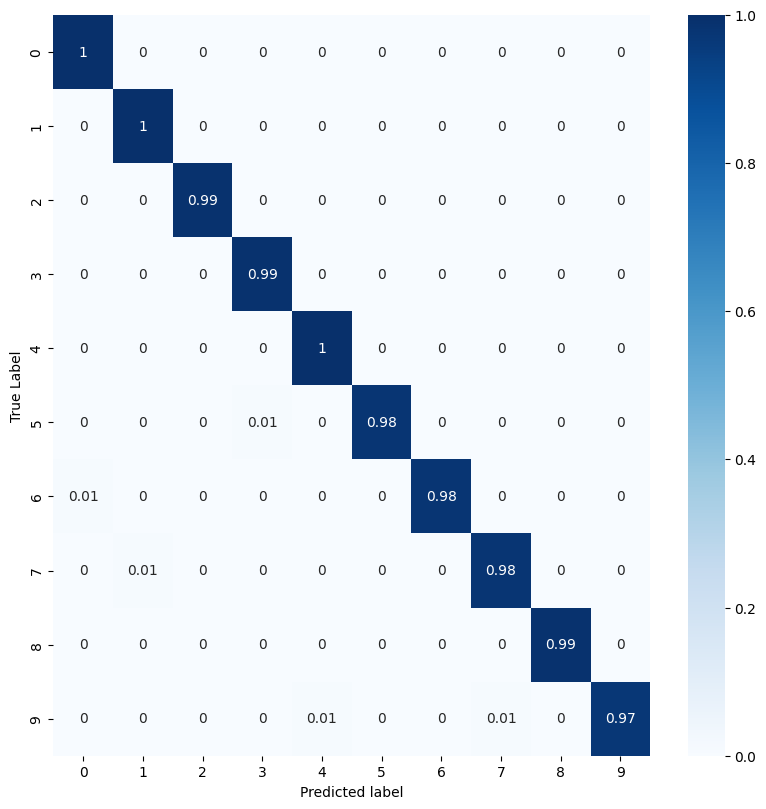

In [108]:
#Geração da Matriz de confusão
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.round(con_mat.astype('float') / con_mat.sum(axis=1)[:,np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)

figure = plt.figure(figsize=(8,8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.show()

In [109]:
# Contagem das classificações corretas e incorretas

# total de amostras no conjunto de teste
total_instancias = test_images.shape[0]
total_classes = len(classes)

# TN, TP, FN, FP
VN = [] # Verdadeiro Negativo
VP = [] # Verdadeiro Positivo
FN = [] # Falso Negativo
FP = [] # Falso Positivo

# Soma de todos os outros elementos (nem verdadeiros da classe nem previstos como a classe em questão)
def obter_VN(array_matriz_de_confusao, classe):
  total_VN = 0
  for i in range(total_classes):
    for j in range(total_classes):
      if i != classe and j != classe:
        total_VN += array_matriz_de_confusao[i, j]
  return total_VN

for classe in range(total_classes):
  VP.append(con_mat[classe, classe])
  FN.append(con_mat[classe, :].sum() - con_mat[classe, classe])
  FP.append(con_mat[:, classe].sum() - con_mat[classe, classe])
  VN.append(obter_VN(con_mat, classe))

# Resultados
for classe in range(total_classes):
  print(f"Classe: {classe}")
  print(f"\tVerdadeiros Positivos: {VP[classe]}")
  print(f"\tVerdadeiros Negativos: {VN[classe]}")
  print(f"\tFalsos Positivos: {FP[classe]}")
  print(f"\tFalsos Negativos: {FN[classe]}")

Classe: 0
	Verdadeiros Positivos: 978
	Verdadeiros Negativos: 9005
	Falsos Positivos: 15
	Falsos Negativos: 2
Classe: 1
	Verdadeiros Positivos: 1135
	Verdadeiros Negativos: 8839
	Falsos Positivos: 26
	Falsos Negativos: 0
Classe: 2
	Verdadeiros Positivos: 1017
	Verdadeiros Negativos: 8965
	Falsos Positivos: 3
	Falsos Negativos: 15
Classe: 3
	Verdadeiros Positivos: 1003
	Verdadeiros Negativos: 8980
	Falsos Positivos: 10
	Falsos Negativos: 7
Classe: 4
	Verdadeiros Positivos: 979
	Verdadeiros Negativos: 8998
	Falsos Positivos: 20
	Falsos Negativos: 3
Classe: 5
	Verdadeiros Positivos: 874
	Verdadeiros Negativos: 9105
	Falsos Positivos: 3
	Falsos Negativos: 18
Classe: 6
	Verdadeiros Positivos: 943
	Verdadeiros Negativos: 9037
	Falsos Positivos: 5
	Falsos Negativos: 15
Classe: 7
	Verdadeiros Positivos: 1012
	Verdadeiros Negativos: 8951
	Falsos Positivos: 21
	Falsos Negativos: 16
Classe: 8
	Verdadeiros Positivos: 963
	Verdadeiros Negativos: 9018
	Falsos Positivos: 8
	Falsos Negativos: 11
Class

In [110]:
# Cálculo da Acurácia: a proporção de previsões corretas (acertos) em relação ao total de previsões.
acuracia_geral = np.trace(con_mat) / total_instancias

# Acurácia geral: total de previsões corretas pelo total de instancias do conjunto de teste
print(f"Proporção de acertos (Acurácia geral): {acuracia_geral:.4f}")
print(f"Proporção de erros: {(1-acuracia_geral):.4f}" )

Proporção de acertos (Acurácia geral): 0.9884
Proporção de erros: 0.0116


## Métricas por classe

In [111]:
# Acurácia por classe
print("Acurácia por classe:".upper())
for classe in range(total_classes):
    print(f"Classe{classe}= {round((VP[classe]+VN[classe])/(VP[classe]+VN[classe]+FP[classe]+FN[classe]), 3)}")

ACURÁCIA POR CLASSE:
Classe0= 0.998
Classe1= 0.997
Classe2= 0.998
Classe3= 0.998
Classe4= 0.998
Classe5= 0.998
Classe6= 0.998
Classe7= 0.996
Classe8= 0.998
Classe9= 0.997


In [112]:
# Cálculo da Sensibilidade / Recall / Revocação: proporção de acertos da classe positiva em relação ao total de instâncias reais da classe positiva.
print("Sensibilidade por classe:".upper())
for classe in range(total_classes):
  sensibilidade = VP[classe] / (VP[classe] + FN[classe]) if (VP[classe] + FN[classe]) > 0 else 0
  print(f"Classe{classe}= {sensibilidade:.3f}")

SENSIBILIDADE POR CLASSE:
Classe0= 0.998
Classe1= 1.000
Classe2= 0.985
Classe3= 0.993
Classe4= 0.997
Classe5= 0.980
Classe6= 0.984
Classe7= 0.984
Classe8= 0.989
Classe9= 0.971


In [113]:
# Cálculo da Especificidade: proporção de acertos da classe negativa em relação ao total de instâncias reais da classe negativa.
print("Especificidade por classe:".upper())
for classe in range(total_classes):
  especificidade = VN[classe]/(VN[classe]+FP[classe]) if (VN[classe]+FP[classe]) > 0 else 0
  print(f"Classe{classe}= {especificidade:.3f}")

ESPECIFICIDADE POR CLASSE:
Classe0= 0.998
Classe1= 0.997
Classe2= 1.000
Classe3= 0.999
Classe4= 0.998
Classe5= 1.000
Classe6= 0.999
Classe7= 0.998
Classe8= 0.999
Classe9= 0.999


In [114]:
# Cálculo da Precisão: proporção de acertos da classe positiva em relação ao total de instâncias classificadas como da classe positiva.
print("Precisão por classe:".upper())
for classe in range(total_classes):
  precisao = VP[classe] / (VP[classe] + FP[classe]) if (VP[classe] + FP[classe]) > 0 else 0
  print(f"Classe{classe}= {precisao:.3f}")

PRECISÃO POR CLASSE:
Classe0= 0.985
Classe1= 0.978
Classe2= 0.997
Classe3= 0.990
Classe4= 0.980
Classe5= 0.997
Classe6= 0.995
Classe7= 0.980
Classe8= 0.992
Classe9= 0.995


In [115]:
# Cálculo da F1-score: quanto das previsões positivas estavam corretas e quanto dos positivos reais foram capturados.
#Média harmônica entre precisão e sensibilidade: equilíbrio para evitar falsos positivos e falsos negativos.
print("F1-score por classe:".upper())

for classe in range(total_classes):
    precisao = VP[classe] / (VP[classe] + FP[classe]) if (VP[classe] + FP[classe]) > 0 else 0
    sensibilidade = VP[classe] / (VP[classe] + FN[classe]) if (VP[classe] + FN[classe]) > 0 else 0

    # F1-score: média harmônica de precisão e recall
    if precisao + sensibilidade > 0:
        f1_score = 2 * (precisao * sensibilidade) / (precisao + sensibilidade)
    else:
        f1_score = 0

    print(f"Classe {classe} = {f1_score:.3f}")


F1-SCORE POR CLASSE:
Classe 0 = 0.991
Classe 1 = 0.989
Classe 2 = 0.991
Classe 3 = 0.992
Classe 4 = 0.988
Classe 5 = 0.988
Classe 6 = 0.990
Classe 7 = 0.982
Classe 8 = 0.990
Classe 9 = 0.983


In [119]:
# Gerando as mesmas métricas por meio da biblioteca Scikit-Learn
from sklearn.metrics import f1_score, precision_score, recall_score

con_mat = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", con_mat)

acc = accuracy_score(y_true, y_pred)
print(f"Acurácia geral: {acc:.3f}")

# Convert the integer class labels to strings for target_names
target_names_str = [str(c) for c in classes]
report = classification_report(y_true, y_pred, target_names=target_names_str, digits=3)
print(report)

# Macro: média aritmética das classes
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro    = recall_score(y_true, y_pred, average='macro')
f1_macro        = f1_score(y_true, y_pred, average='macro')

# Micro: média ponderada pelo número de instâncias
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro    = recall_score(y_true, y_pred, average='micro')
f1_micro        = f1_score(y_true, y_pred, average='micro')

print(f"\nMacro F1: {f1_macro:.3f}\nMicro F1: {f1_micro:.3f}")

Matriz de Confusão:
 [[ 978    1    0    0    0    0    0    1    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   3    2 1017    1    3    0    0    5    1    0]
 [   0    0    1 1003    0    1    0    4    1    0]
 [   0    1    0    0  979    0    1    0    0    1]
 [   0    1    0    8    0  874    3    1    4    1]
 [   9    3    0    0    1    0  943    0    2    0]
 [   0   14    1    0    0    0    0 1012    0    1]
 [   2    2    1    1    1    0    1    1  963    2]
 [   1    2    0    0   15    2    0    9    0  980]]
Acurácia geral: 0.988
              precision    recall  f1-score   support

           0      0.985     0.998     0.991       980
           1      0.978     1.000     0.989      1135
           2      0.997     0.985     0.991      1032
           3      0.990     0.993     0.992      1010
           4      0.980     0.997     0.988       982
           5      0.997     0.980     0.988       892
           6      0.995     0.984     0.990    

| Média    | Como calcula                                | Peso das classes                | Interpretação                     |
| -------- | ------------------------------------------- | ------------------------------- | --------------------------------- |
| Macro    | Média simples das métricas por classe       | Todas iguais                    | Avalia uniformidade entre classes |
| Weighted | Média ponderada pelo suporte de cada classe | Maior peso para classes maiores | Reflete distribuição real         |
| Micro    | Soma global de VP, FP, FN antes de calcular | Implícito: todas instâncias     | Avalia desempenho global total    |


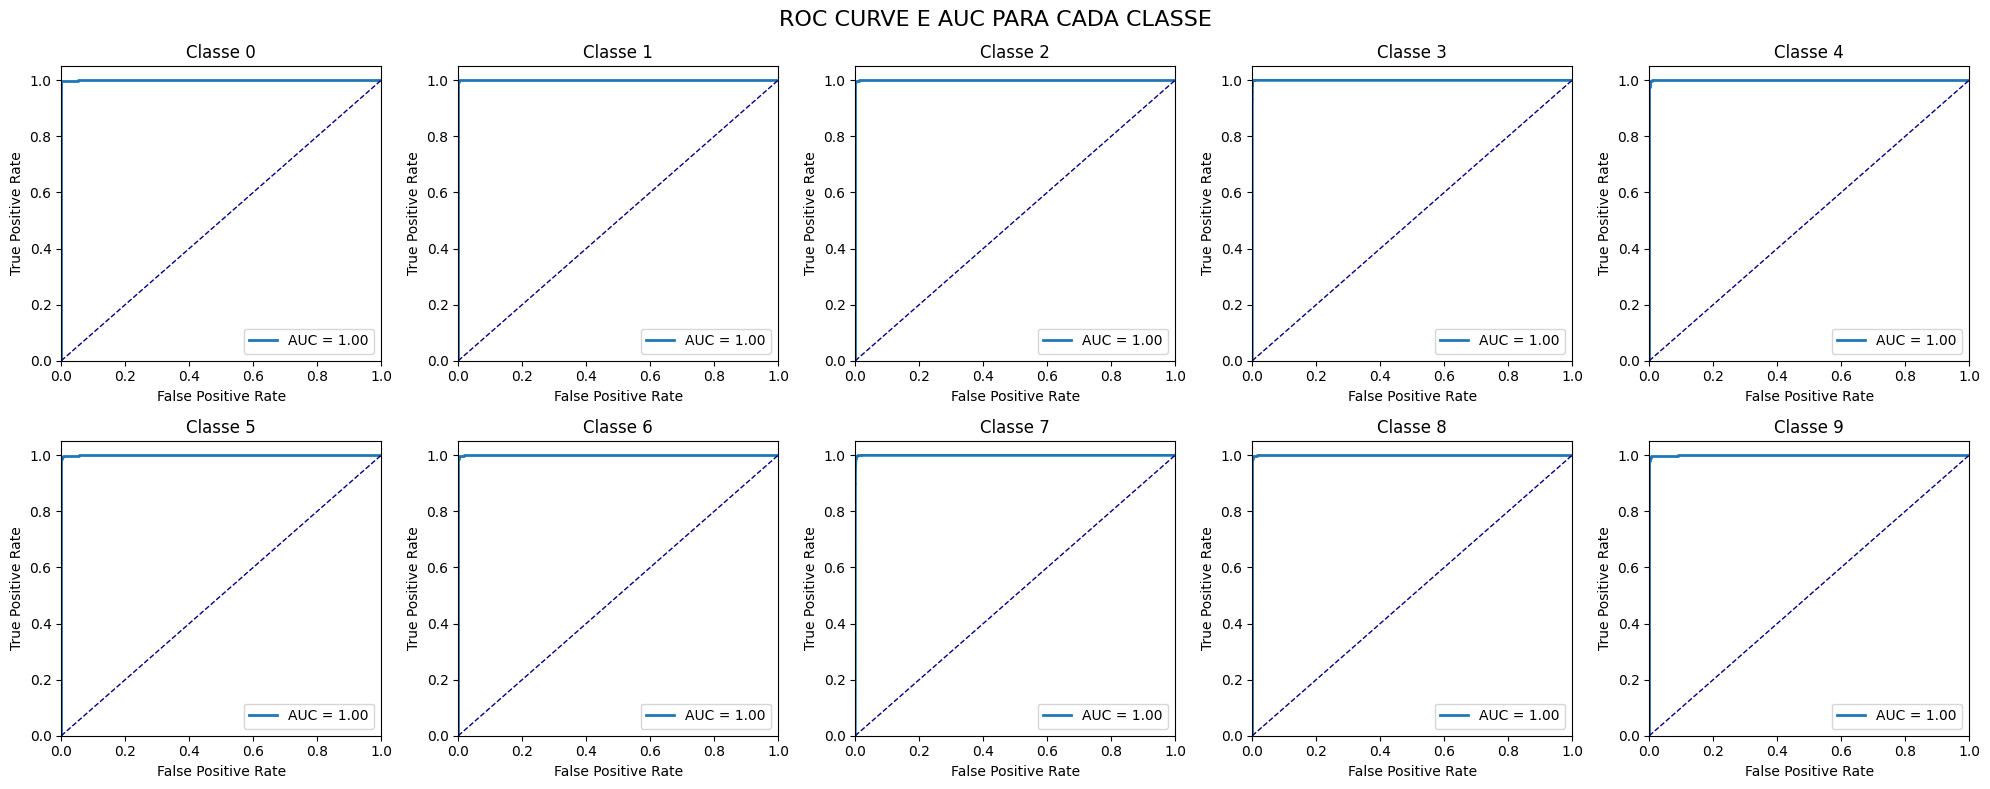

In [118]:
# Roc curve precisa dos vetores binários (0 ou 1) para os rótulos reais e probabilidades contínuas para as predições.
# Binarizar rótulos
y_true_bin = label_binarize(y_true, classes=classes)

# parâmetros
total_classes = len(classes)
fp_rate = dict()
tp_rate = dict()
roc_auc = dict()

# Calcular ROC curve e AUC para cada classe
for classe in range(total_classes):
    fp_rate[classe], tp_rate[classe], _ = roc_curve(y_true_bin[:, classe], y_scores[:, classe])
    roc_auc[classe] = auc(fp_rate[classe], tp_rate[classe])

# Plot ROC curves por classe
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for classe in range(total_classes):
    axes[classe].plot(fp_rate[classe], tp_rate[classe], lw=2, label=f'AUC = {roc_auc[classe]:.2f}')
    axes[classe].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    axes[classe].set_xlim([0.0, 1.0])
    axes[classe].set_ylim([0.0, 1.05])
    axes[classe].set_xlabel('False Positive Rate')
    axes[classe].set_ylabel('True Positive Rate')
    axes[classe].set_title(f'Classe {classe}')
    axes[classe].legend(loc="lower right")

fig.suptitle("ROC curve e AUC para cada classe".upper(), fontsize=16)
plt.tight_layout()
plt.show()

## Resultados

Todas as classes apresentaram métricas com valores próximos de 0.98. O menor valor foi 0.979, referente à precisão da classe 5, indicando que essa classe teve um número ligeiramente maior de falsos positivos em comparação às demais.

Contudo, os resultados demonstram uma excelente capacidade de classificação das imagens do *dataset MNIST* pelo modelo.